In [34]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [2]:
a= np.array([[10,7,4],[3,2,1]])
np.percentile(a,5,axis=0)

array([3.35, 2.25, 1.15])

In [9]:
csv_path='/Users/Roni_Ariel/Documents/Master_Research/VideoData/output_files/frog_calls_clusters.csv'
data= pd.read_csv(csv_path)
frog_sequence = data['frog_id_kmm']
unique_frogs = sorted(frog_sequence.unique())
n_frogs = len(unique_frogs)
print(n_frogs)

7


In [10]:
def compute_transition_matrix(sequence):
    """Compute the transition probability matrix for a given sequence."""
    current_frogs = sequence[:-1]
    next_frogs = sequence.shift(-1)[:-1]
    transition_pairs = pd.DataFrame({'current': current_frogs, 'next': next_frogs})

    # Calculate counts
    transition_counts = pd.crosstab(transition_pairs['current'], transition_pairs['next'])

    # Reindex to include all frogs
    transition_counts = transition_counts.reindex(index=unique_frogs, columns=unique_frogs, fill_value=0)

    # Normalize to probabilities
    transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)


    return transition_probs


In [5]:
def check_null_distribution(matrix_from_shuffled): 
    for i in range(n_frogs):
        for j in range(n_frogs):
            all_data= matrix_from_shuffled[:,i,j]
            unique_probs,counts= np.unique(all_data,return_counts= True)
            plt.figure(figsize=(4, 3))
            plt.plot(unique_probs, counts, linestyle='-', color='blue', label=f'P({i} → {j})')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.title(f'Frequency Distribution for P({i} → {j})')
            plt.legend()
            plt.grid(True)
            plt.show()
            

In [6]:
def check_distribution(matrix_from_shuffled): #doesn't follow normal distribution!
    for i in range(n_frogs):
        for j in range(n_frogs):
            all_data= matrix_from_shuffled[:,i,j].tolist()

            stat,p = shapiro(all_data)
            print("p_ value", i,j ,"is", p)
            if p > 0.05:
                print("Data follows a normal distribution")
            else:
                print("Data does not follow a normal distribution")
    return 

In [7]:
def plot_null_distributions(shuffled_transition_prop,data_transition_prop,save_plots=False):
    lower_threshold= np.percentile(shuffled_transition_prop,5,axis=0)
    upper_threshold= np.percentile(shuffled_transition_prop,95,axis=0)
    non_significant_values = []
    for i in range(n_frogs):
        for j in range(n_frogs):
            observed_value= data_transition_prop[i,j]
            lower_val= lower_threshold[i,j]
            upper_val= upper_threshold[i,j]
          
            plt.figure(figsize=(4, 3))

            # Plot the histogram for P(i -> j)
            plt.hist(shuffled_transition_prop[:,i,j], bins=32, color='lightblue', alpha=0.7, label='Null Distribution')

            # Add thresholds and observed value
            plt.axvline(lower_val, color='red', linestyle='--', label='5% Lower Threshold')
            plt.axvline(upper_val, color='green', linestyle='--', label='95% Upper Threshold')
            plt.axvline(observed_value, color='blue', linestyle='-', label='Observed Value')

            # Add labels and legend
            plt.title(f'P({i} → {j})')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.legend()

            # Save or show the plot
            # if save_plots:
            #     filename = f'P({i}_to_{j}).png'
            #     plt.savefig(filename, dpi=300)
            #     print(f"Saved plot: {filename}")
            # else:
            plt.show()

            if not (observed_value <= lower_val or observed_value >= upper_val):
                non_significant_values.append((i, j, observed_value))

    print("Non-Significant Values (i, j, observed value):")
    for i, j, value in non_significant_values:
        print(f"({i}, {j}, {value:.4f})")

        
            
            

In [35]:
def correct_p_values_fdr(shuffled_transition_prop,data_transition_prop,n_shuffles,q):
    vals_grt_observed=np.divide(((shuffled_transition_prop >= data_transition_prop).sum(axis=0)),n_shuffles)
    vals_less_observed=np.divide((( shuffled_transition_prop < data_transition_prop).sum(axis=0)),n_shuffles)
    p_values= 2*(np.minimum(vals_grt_observed,vals_less_observed))
    flatten_p_values= p_values.flatten()
    flatten_sorted_p_values= np.sort(flatten_p_values)
    # m= n_frogs*n_frogs
    # rank = np.arange(1,m+1)
    # thresholds=(rank / m)*q
    # # print("treshold", thresholds)
    # # print("flatten_p_values", flatten_sorted_p_values)
    # significant_p_values= flatten_sorted_p_values <= thresholds
    # print(significant_p_values)
    return multipletests(flatten_p_values,alpha=q,method='fdr_bh')
    

In [40]:

def plot_dyads(matrix_shuffled, observed_matrix, title="Observed vs Null Transition Probabilities"):
    """
    Plots the observed probabilities against the null distribution for each dyad.
    
    Parameters:
        matrix_from_shuffled (numpy.ndarray): Null distribution matrix (shuffles x frogs x frogs).
        observed_matrix (numpy.ndarray): Observed transition probability matrix (frogs x frogs).
        title (str): Title of the plot.
    """
    # Step 1: Compute mean and standard deviation for null distribution
    mean_null = matrix_shuffled.mean( axis=0)
    std_null = matrix_shuffled.std( axis=0)
    
    # Step 2: Flatten the matrices to work with dyads as a list
    mean_null_flat = mean_null.flatten()
    std_null_flat = std_null.flatten()
    observed_probs_flat = observed_matrix.flatten()
 
#     
#     # Step 3: Sort dyads by the mean of the null distribution
#     sorted_indices = np.argsort(mean_null_flat)[::-1]  # Descending order
#     mean_null_sorted = mean_null_flat[sorted_indices]
#     std_null_sorted = std_null_flat[sorted_indices]
#     observed_probs_sorted = observed_probs_flat[sorted_indices]
#     
#     # Step 4: Plot
#     n_dyads = len(mean_null_sorted)
    x = np.arange(49)  # Dyads on the x-axis
# 
    plt.figure(figsize=(24, 12))
#     
#     # # Plot the null distribution (gray bars with error bars)
# 
    plt.bar(x,2*std_null_flat,bottom=mean_null_flat - std_null_flat, 
    color='gray', alpha=0.5, label='Mean+-SD' 
)
#     # Plot the observed probabilities (black dots)
    plt.scatter(x, observed_probs_flat, color='red', label='Observed Probabilities', zorder=3)
    
    # # Add labels and legend
    plt.xlabel('Dyads (Pairs of Frogs)')
    plt.ylabel('Transition Probability')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig('Observed vs Null Transition Probabilities',dpi=300,bbox_inches='tight')


In [12]:
def generate_shuffled_sequences(n_shuffles):
    
    shuffled_matrices = []

    for i in range(n_shuffles):
        shuffled_sequence = frog_sequence.sample(frac=1).reset_index(drop=True)  # Shuffle
        shuffled_probs = compute_transition_matrix(shuffled_sequence).to_numpy()
        shuffled_matrices.append(shuffled_probs)
        
    shuffled_matrices = np.array(shuffled_matrices)


    return shuffled_matrices


In [13]:
def generate_data_probabilities_matrix():
    transition_probabilities= compute_transition_matrix(frog_sequence)
    return transition_probabilities.to_numpy()

In [14]:
observed_matrix= generate_data_probabilities_matrix()

In [15]:
all_shuffled_matrix = generate_shuffled_sequences(n_shuffles=1000)

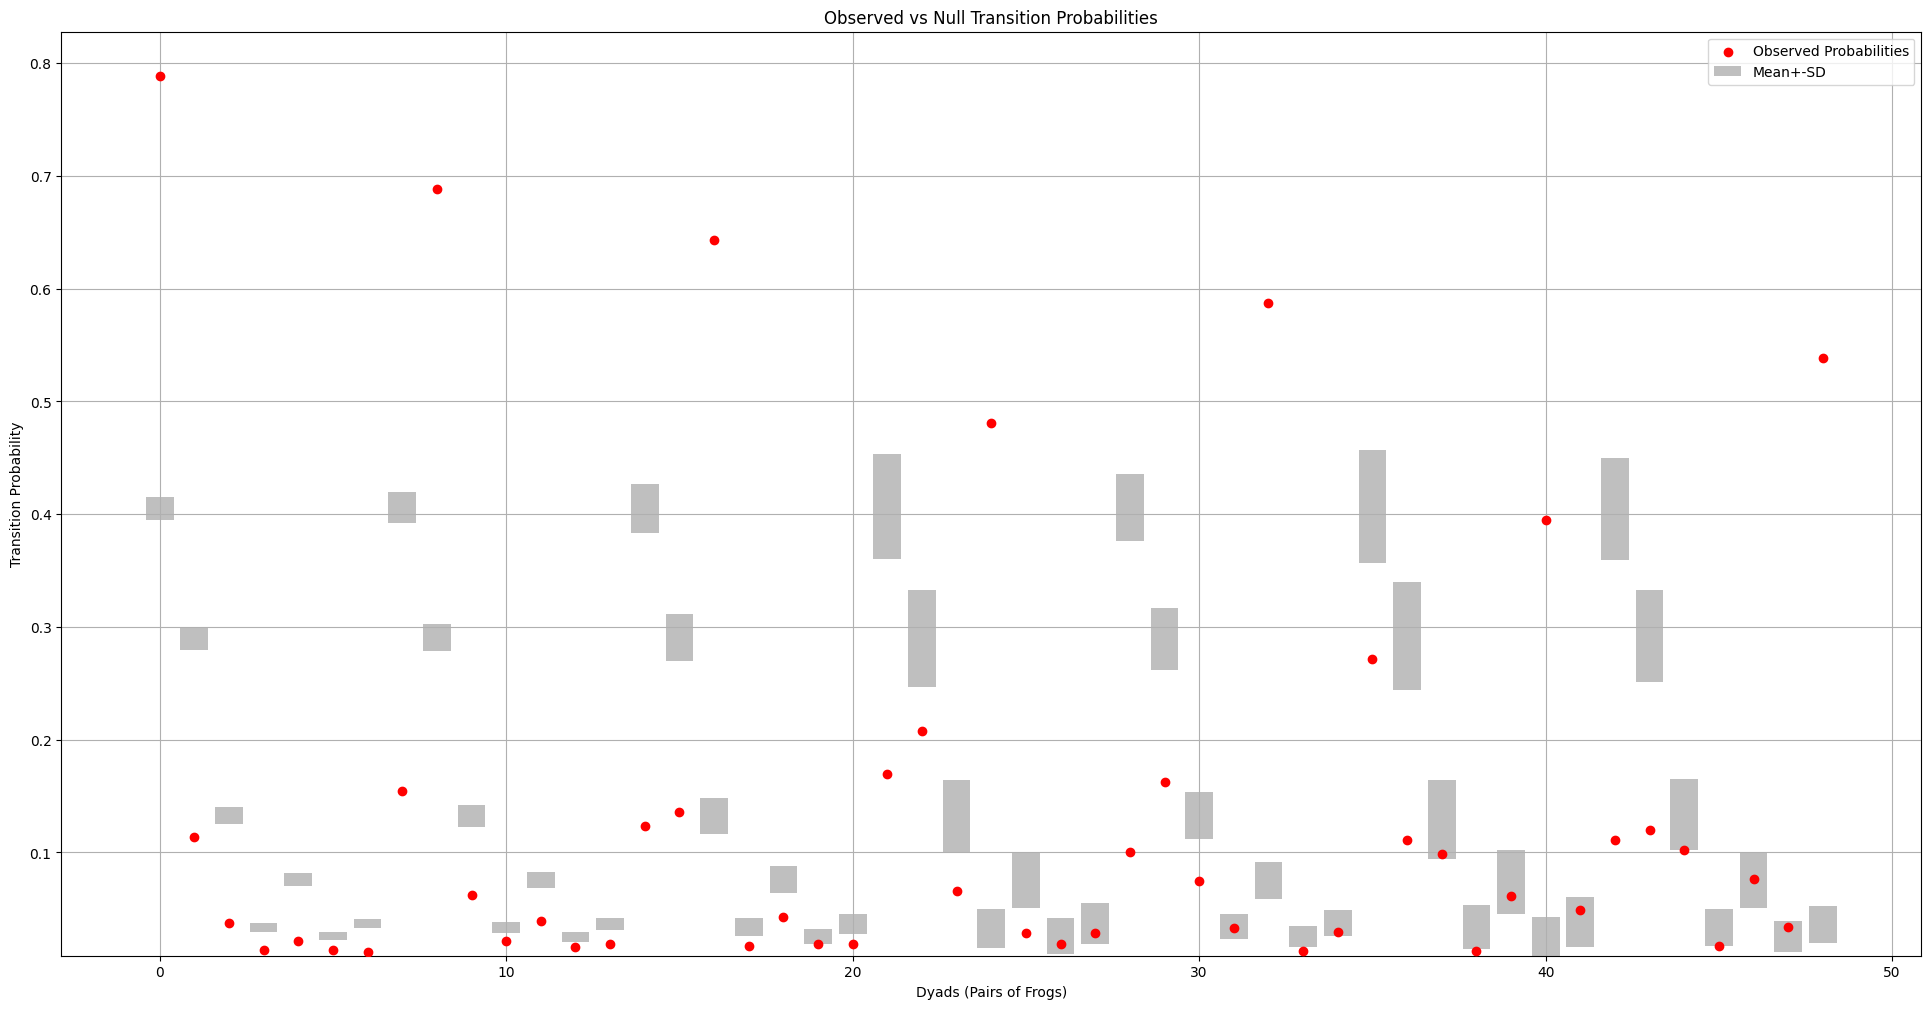

In [41]:
plot_dyads(all_shuffled_matrix, observed_matrix)

In [36]:
reject,pvals_corrected,_,_= correct_p_values_fdr(all_shuffled_matrix,observed_matrix,1000,0.05)
print("reject", reject)
print("fdr correct p values", pvals_corrected)

reject [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True False False  True  True  True False  True False False  True
  True False False False  True False  True  True False False False False
  True]
fdr correct p values [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02286667 0.
 0.04035294 0.         0.         0.         0.         0.02027586
 0.00376923 0.32268293 0.03860606 0.         0.0728     0.02845161
 0.         0.03675    0.53454545 0.53454545 0.         0.
 0.00725926 0.79829167 0.         0.11977778 0.476      0.014
 0.         0.32268293 0.14302703 0.60977778 0.         0.7527234
 0.         0.         0.32268293 0.25273684 0.936      0.72647826
 0.        ]


In [37]:
print("reject", np.sum(reject))

reject 34


In [18]:
print(all_shuffled_matrix.mean(axis=0))

[[0.40514767 0.28998736 0.13282404 0.03335651 0.0759734  0.02574789
  0.03696314]
 [0.40580187 0.29052984 0.13222901 0.0334178  0.07579505 0.02535848
  0.03686795]
 [0.40524972 0.29072822 0.13248508 0.03361068 0.07585961 0.02546967
  0.03659702]
 [0.40725705 0.28973801 0.132231   0.03264672 0.07487817 0.02620845
  0.03704061]
 [0.40598468 0.28938244 0.13297357 0.03420249 0.07505352 0.02524505
  0.03715825]
 [0.40646574 0.29218611 0.12952022 0.03366698 0.07394568 0.02563503
  0.03858025]
 [0.40454811 0.29189191 0.13331145 0.03310109 0.07549359 0.025458
  0.03619584]]


In [20]:
check_null_distribution(all_shuffled_matrix)

NameError: name 'check_null_distribution' is not defined

In [42]:

correct_p_values_fdr(all_shuffled_matrix,observed_matrix,1000,0.05)

treshold [0.00102041 0.00204082 0.00306122 0.00408163 0.00510204 0.00612245
 0.00714286 0.00816327 0.00918367 0.01020408 0.01122449 0.0122449
 0.01326531 0.01428571 0.01530612 0.01632653 0.01734694 0.01836735
 0.01938776 0.02040816 0.02142857 0.02244898 0.02346939 0.0244898
 0.0255102  0.02653061 0.02755102 0.02857143 0.02959184 0.03061224
 0.03163265 0.03265306 0.03367347 0.03469388 0.03571429 0.03673469
 0.0377551  0.03877551 0.03979592 0.04081633 0.04183673 0.04285714
 0.04387755 0.04489796 0.04591837 0.04693878 0.04795918 0.04897959
 0.05      ]
flatten_p_values [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 8.000e-04 2.400e-03 2.800e-03 6.800e-03
 9.200e-03 1.560e-02 1.800e-02 1.840e-02 2.080e-02 2.160e-02 3.760e-02
 1.044e-01 1.268e-01 1.732e-01 2.484e-01 2.732e-01 2.780e-01 4.152e-01
 

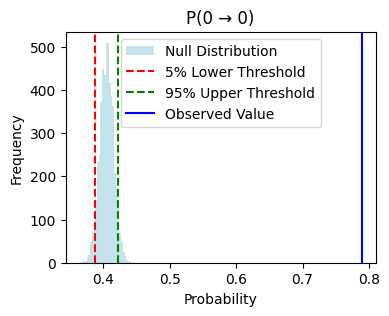

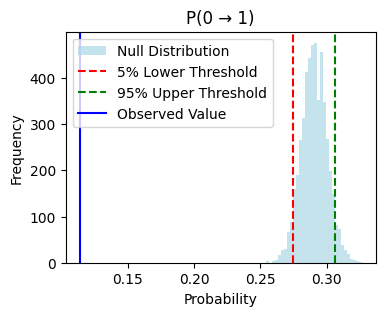

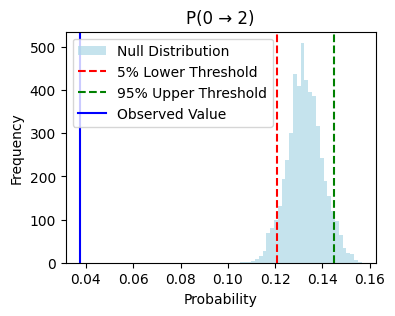

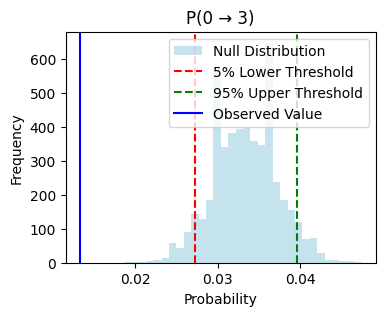

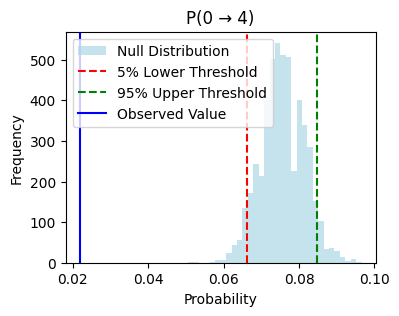

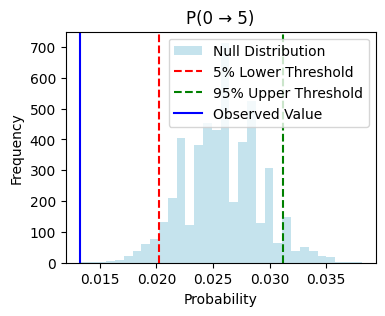

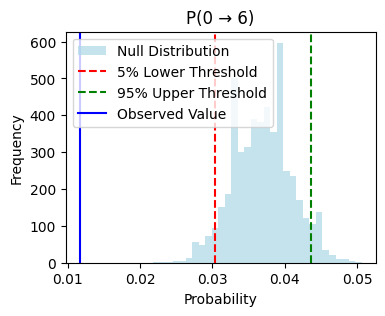

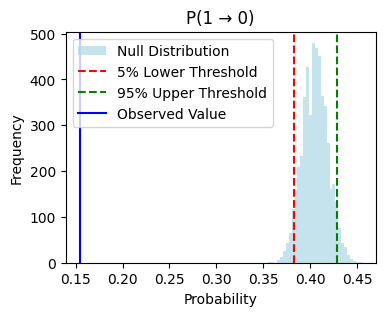

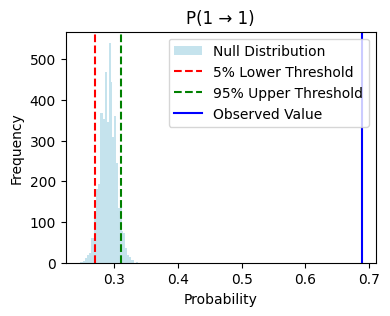

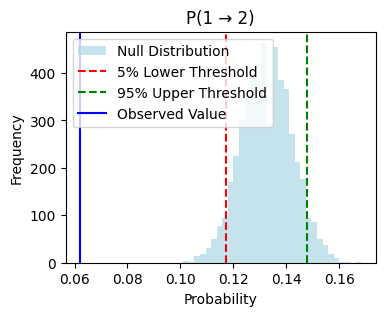

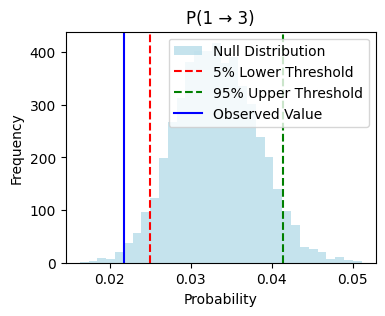

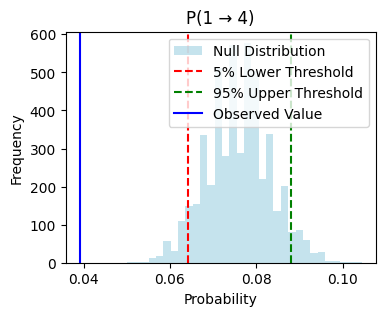

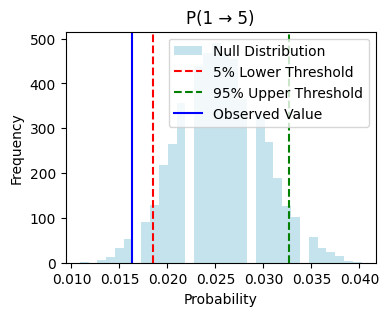

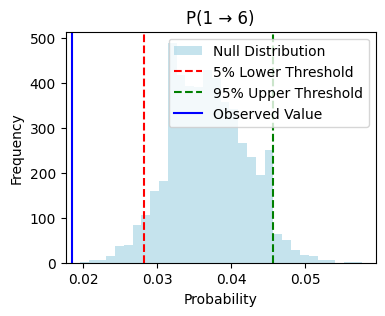

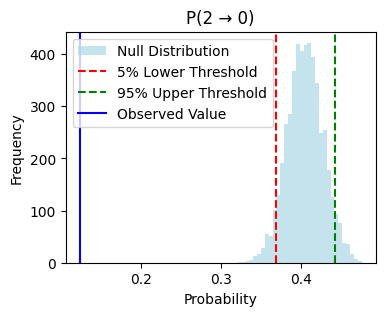

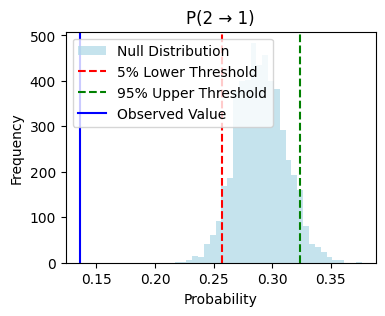

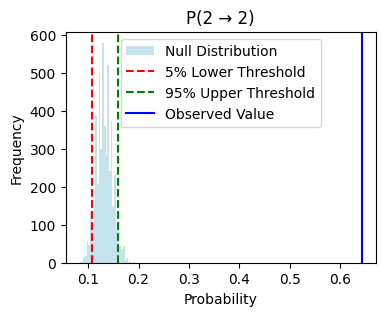

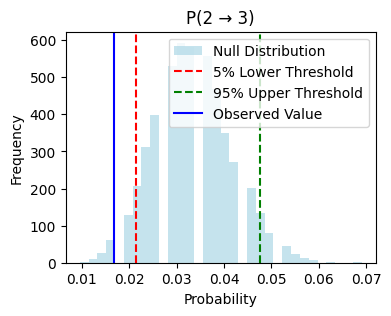

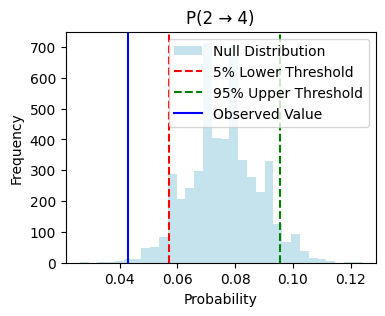

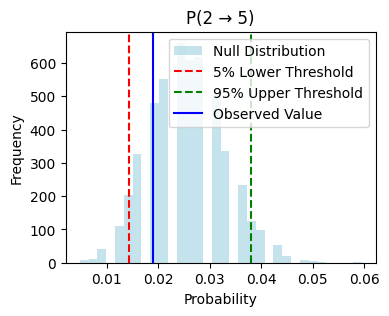

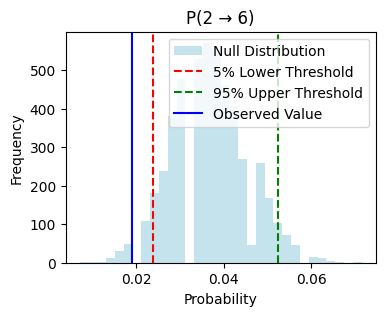

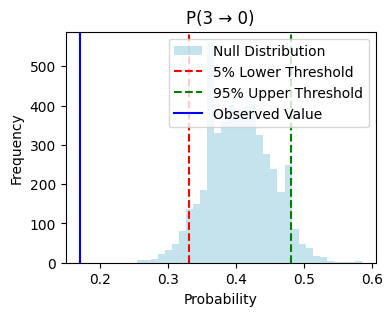

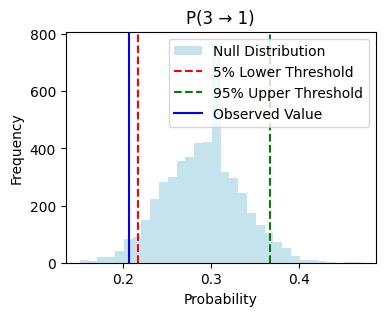

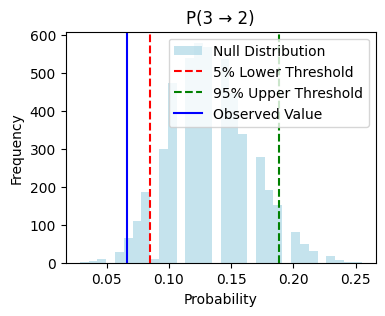

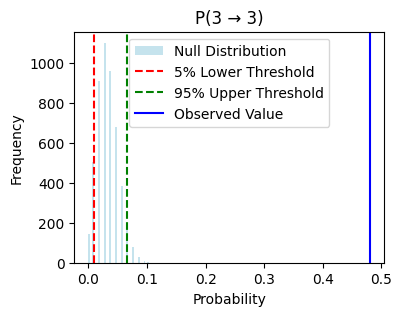

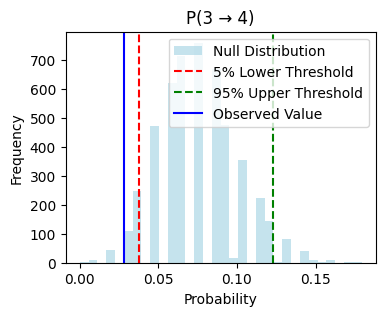

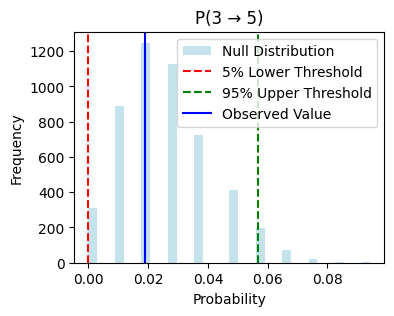

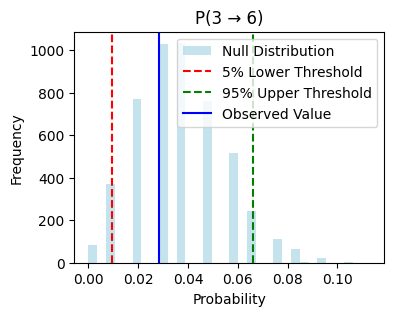

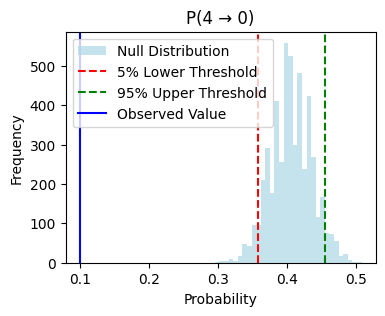

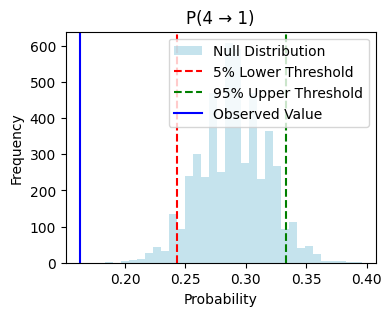

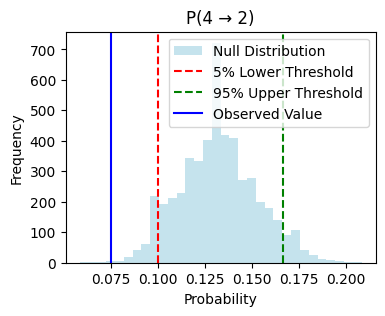

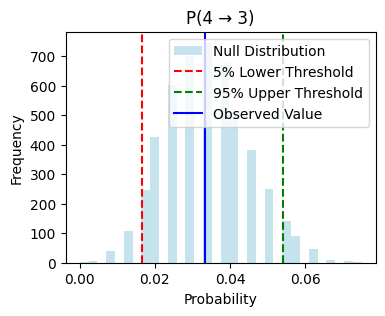

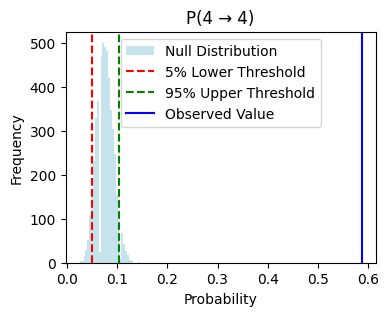

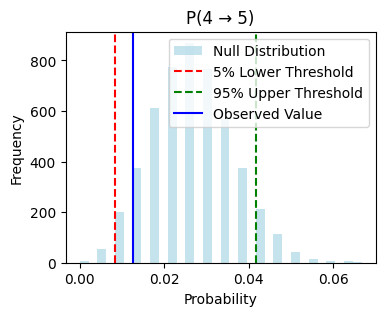

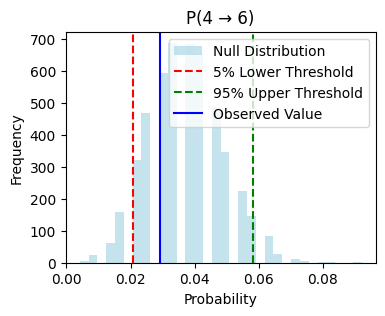

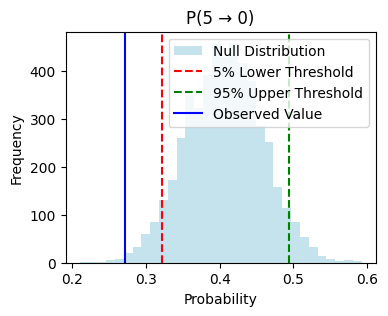

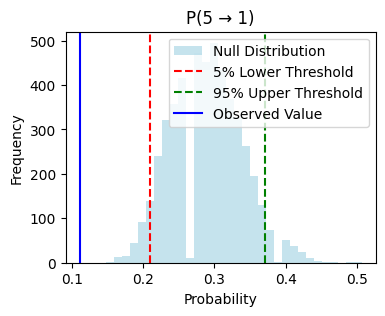

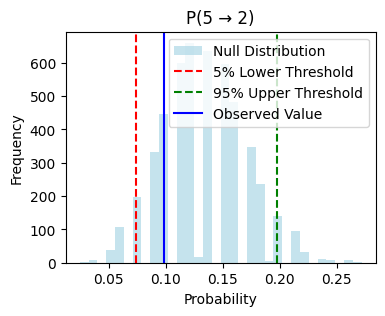

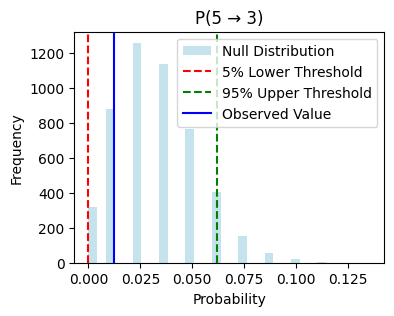

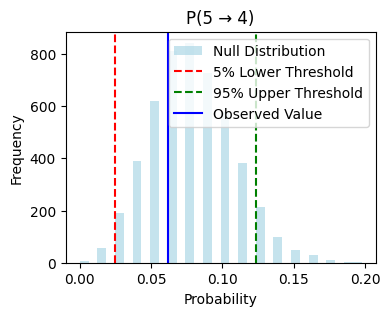

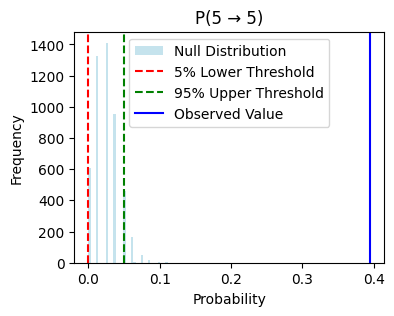

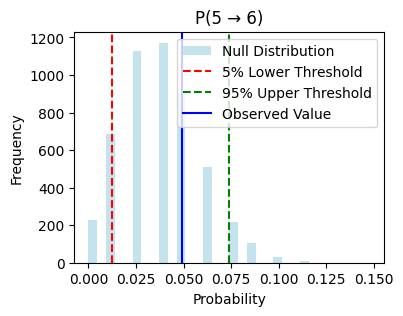

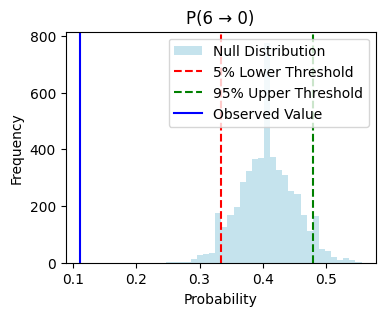

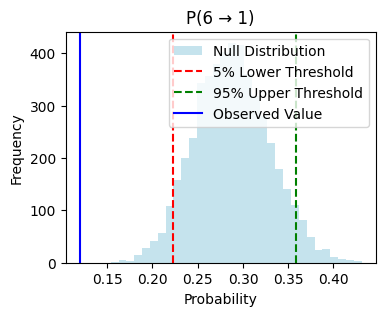

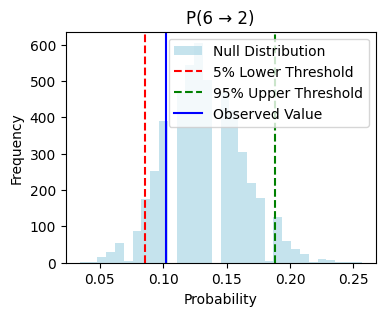

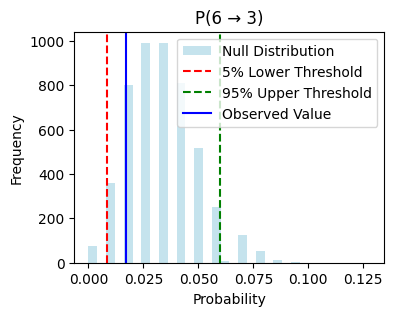

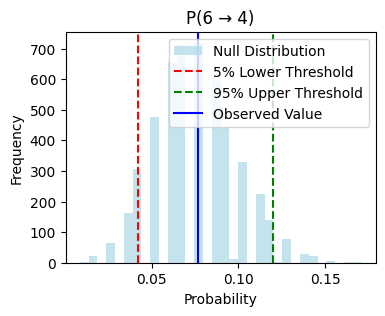

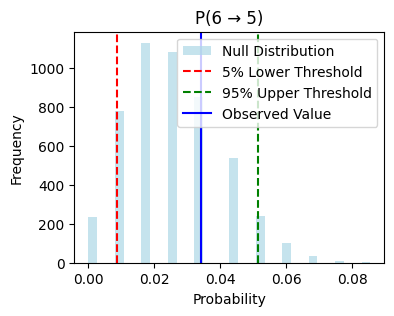

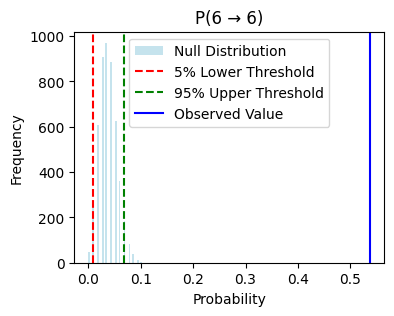

Non-Significant Values (i, j, observed value):
(2, 5, 0.0190)
(3, 5, 0.0189)
(3, 6, 0.0283)
(4, 3, 0.0333)
(4, 5, 0.0125)
(4, 6, 0.0292)
(5, 2, 0.0988)
(5, 3, 0.0123)
(5, 4, 0.0617)
(5, 6, 0.0494)
(6, 2, 0.1026)
(6, 3, 0.0171)
(6, 4, 0.0769)
(6, 5, 0.0342)


In [18]:
plot_null_distributions(all_shuffled_matrix,observed_matrix)